In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm

import utils

In [2]:
chour_dict = {'morning':'04',
              'afternoon':'12',
             }

ampm = 'morning'

critical_hour = chour_dict[ampm]


df = pd.read_csv(f'merged_df_{ampm}.csv',parse_dates=['time'])
time = df['time']
df = df.drop(['time','tmpf','tmpf_pred'],axis=1)
df = df.interpolate('linear')
df.head(8)

,p01i,p01i_pred,speed,hour,speed_diff,lt_32
0,0.0,-0.162157,1.665056,0.512212,0.058170,-0.334726
1,0.0,-0.162157,1.671025,0.611799,0.176360,-0.334726
2,0.0,-0.162157,1.676994,0.698988,0.176360,-0.334726
3,0.0,-0.162157,1.682963,0.773405,0.176360,-0.334726
4,0.0,-0.162157,1.688933,0.834731,0.176360,-0.334726
5,0.0,-0.162157,1.500661,0.882704,-0.592839,-0.334726
6,0.0,-0.162157,1.251523,0.917117,-0.833868,-0.334726
7,0.0,-0.162157,1.081452,0.937824,-0.520763,-0.334726


In [3]:
(train_df,val_df,test_df), num_features = utils.train_test_val_split(df)

In [4]:
input_width = 8
label_width = 8
shift = label_width 

In [5]:
w1 = utils.WindowGenerator(input_width, label_width, shift,train_df, val_df, test_df, label_columns=['speed'])
w1

Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): ['speed']

In [6]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 16, 6)
Inputs shape: (3, 8, 6)
labels shape: (3, 8, 1)


In [7]:
w1.make_dataset(w1.train_df)

test_case = w1.train_df.copy()

In [8]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 8, 6)
Labels shape (batch, time, features): (32, 8, 1)


In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [10]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', linear(w1.example[0]).shape)

Input shape: (32, 8, 6)
Output shape: (32, 8, 1)


In [11]:
val_performance = {}
performance = {}

In [12]:
history = utils.compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 3s 6ms/step - loss: 1.3296 - mean_absolute_error: 0.8837 - val_loss: 0.5813 - val_mean_absolute_error: 0.6091
Epoch 2/20
546/546 [==============================] - 3s 5ms/step - loss: 0.6884 - mean_absolute_error: 0.6395 - val_loss: 0.3763 - val_mean_absolute_error: 0.4992
Epoch 3/20
546/546 [==============================] - 3s 5ms/step - loss: 0.5203 - mean_absolute_error: 0.5702 - val_loss: 0.3488 - val_mean_absolute_error: 0.4878
Epoch 4/20
156/156 [==============================] - 0s 3ms/step - loss: 0.3511 - mean_absolute_error: 0.4913


In [13]:
performance['Linear']

[0.4367945194244385, 0.5368000864982605]

In [14]:
time_test = time[w1.test_df.index]
forecast_starts = pd.date_range(f'2015-01-01 {critical_hour}',f'2019-12-31 {critical_hour}',freq='24h')
valid_inds = time_test[time_test.isin(forecast_starts)].index

(-2.5, 1.5)

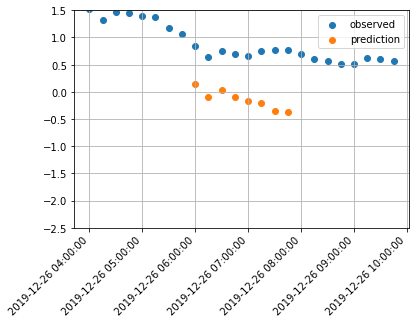

In [15]:
rand_ind = np.random.randint(0,len(valid_inds)-1)
ind_0 = valid_inds[rand_ind]

width = 8
ticks = '1H'

prediction = linear.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()
plt.ylim(-2.5,1.5)

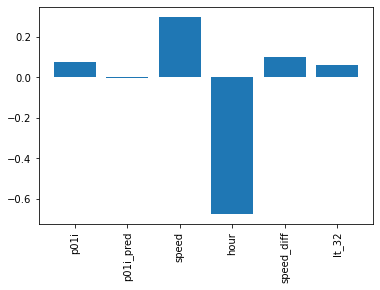

In [16]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [17]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = utils.compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 4s 7ms/step - loss: 0.4405 - mean_absolute_error: 0.5236 - val_loss: 0.3128 - val_mean_absolute_error: 0.4405
Epoch 2/20
546/546 [==============================] - 4s 7ms/step - loss: 0.3670 - mean_absolute_error: 0.4639 - val_loss: 0.2690 - val_mean_absolute_error: 0.4053
Epoch 3/20
546/546 [==============================] - 4s 7ms/step - loss: 0.3362 - mean_absolute_error: 0.4351 - val_loss: 0.2532 - val_mean_absolute_error: 0.3799
Epoch 4/20
546/546 [==============================] - 6s 11ms/step - loss: 0.3249 - mean_absolute_error: 0.4247 - val_loss: 0.2430 - val_mean_absolute_error: 0.3750
Epoch 5/20
546/546 [==============================] - 4s 8ms/step - loss: 0.3163 - mean_absolute_error: 0.4170 - val_loss: 0.2413 - val_mean_absolute_error: 0.3745
Epoch 6/20
546/546 [==============================] - 4s 7ms/step - loss: 0.3124 - mean_absolute_error: 0.4133 - val_loss: 0.2370 - val_mean_absolute_error: 0.3706
Epoch 7/20
156/

(-2.5, 1.5)

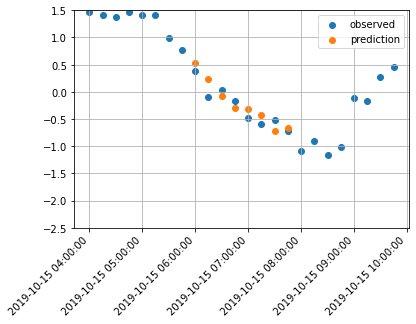

In [18]:
rand_ind = np.random.randint(0,len(valid_inds)-1)
ind_0 = valid_inds[rand_ind]

width = 8
ticks = '1H'

prediction = dense.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()
plt.ylim(-2.5,1.5)

In [19]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(label_width*num_features,
                          kernel_initializer=tf.keras.initializers.glorot_normal(),
                          bias_initializer=tf.keras.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([label_width, num_features])
])

history = utils.compile_and_fit(multi_lstm_model, w1)

val_performance['LSTM'] = multi_lstm_model.evaluate(w1.val)
performance['LSTM'] = multi_lstm_model.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 6s 10ms/step - loss: 0.3590 - mean_absolute_error: 0.4479 - val_loss: 0.2049 - val_mean_absolute_error: 0.3384
Epoch 2/20
546/546 [==============================] - 5s 10ms/step - loss: 0.2094 - mean_absolute_error: 0.3375 - val_loss: 0.1777 - val_mean_absolute_error: 0.3116
Epoch 3/20
546/546 [==============================] - 6s 10ms/step - loss: 0.1885 - mean_absolute_error: 0.3182 - val_loss: 0.1632 - val_mean_absolute_error: 0.2996
Epoch 4/20
546/546 [==============================] - 7s 12ms/step - loss: 0.1778 - mean_absolute_error: 0.3080 - val_loss: 0.1585 - val_mean_absolute_error: 0.2900
Epoch 5/20
546/546 [==============================] - 6s 11ms/step - loss: 0.1693 - mean_absolute_error: 0.2995 - val_loss: 0.1552 - val_mean_absolute_error: 0.2900
Epoch 6/20
546/546 [==============================] - 6s 11ms/step - loss: 0.1642 - mean_absolute_error: 0.2945 - val_loss: 0.1474 - val_mean_absolute_error: 0.2814
Epoch 7/20

In [47]:
time_test = time[(df['lt_32']>1) & (df['p01i']>0)]
# time_test = time[df.index]
forecast_starts = pd.date_range(f'2015-01-01 {critical_hour}',f'2019-12-31 {critical_hour}',freq='24h')
valid_inds = time_test[time_test.isin(forecast_starts)].index

(-2.5, 1.5)

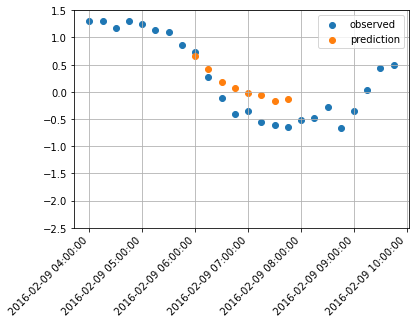

In [48]:
rand_ind = np.random.randint(0,len(valid_inds)-1)
ind_0 = valid_inds[rand_ind]

width = 8
ticks = '1H'

prediction = multi_lstm_model.predict(df[ind_0:ind_0+width].values[np.newaxis,])

prediction = prediction[0,:,1]

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()
plt.ylim(-2.5,1.5)

In [27]:
 multi_lstm_model.save(f'weather_{ampm}')

INFO:tensorflow:Assets written to: weather_morning/assets
